In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical

In [2]:
datax = np.load(join('data', 'MNIST.npy'))
datay = np.load(join('data', 'Label.npy'))

In [3]:
datax_norm = datax/255
print('최대 : {}, 최소 : {}'.format(np.max(datax_norm), np.min(datax_norm)))

최대 : 1.0, 최소 : 0.0


In [4]:
datax_reshape = datax_norm.reshape([60000, 28*28])

In [5]:
#input
input_shape = (28*28,)
input_tensor = layers.Input(input_shape)

#encoder
encoder1 = layers.Dense(300, activation='relu')(input_tensor)
encoder2 = layers.Dense(100, activation='relu')(encoder1)

latent_tensor = encoder2

##eecoder
decoder1 = layers.Dense(300, activation="relu")(latent_tensor)


#Outputs
reconstruction_output = layers.Dense(28*28, activation='relu')(decoder1) 

2022-05-17 16:28:45.681917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:28:45.709612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:28:45.709696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 16:28:45.710259: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
ae = models.Model(input_tensor, reconstruction_output)
ae.compile(optimizer = 'Adam', loss = 'mse')

In [7]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 300)               30300     
                                                                 
 dense_3 (Dense)             (None, 784)               235984    
                                                                 
Total params: 531,884
Trainable params: 531,884
Non-trainable params: 0
_________________________________________________________________


In [8]:
#parameter
epoch = 10
batch_size = 1024
ae.fit(datax_reshape, datax_reshape, batch_size =batch_size, epochs = epoch, verbose = 2)

Epoch 1/10


2022-05-17 16:28:46.933663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


59/59 - 1s - loss: 0.0506 - 802ms/epoch - 14ms/step
Epoch 2/10
59/59 - 0s - loss: 0.0193 - 281ms/epoch - 5ms/step
Epoch 3/10
59/59 - 0s - loss: 0.0136 - 195ms/epoch - 3ms/step
Epoch 4/10
59/59 - 0s - loss: 0.0115 - 186ms/epoch - 3ms/step
Epoch 5/10
59/59 - 0s - loss: 0.0105 - 199ms/epoch - 3ms/step
Epoch 6/10
59/59 - 0s - loss: 0.0097 - 366ms/epoch - 6ms/step
Epoch 7/10
59/59 - 0s - loss: 0.0092 - 236ms/epoch - 4ms/step
Epoch 8/10
59/59 - 0s - loss: 0.0089 - 218ms/epoch - 4ms/step
Epoch 9/10
59/59 - 0s - loss: 0.0085 - 193ms/epoch - 3ms/step
Epoch 10/10
59/59 - 0s - loss: 0.0083 - 297ms/epoch - 5ms/step


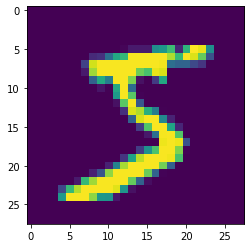

In [9]:
#원본 데이터 
plt.imshow(datax_reshape[0].reshape(28,28))

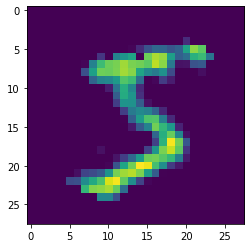

In [10]:
#데이터를 모델에 넣고 복원
decoded_img = ae.predict(datax_reshape[0].reshape(1, 28*28))
decoded_img = decoded_img.reshape(28,28)

#복원된 데이터 확인
plt.imshow(decoded_img)

In [11]:
#novelty detector
np.mean(np.abs(datax_reshape[0] - decoded_img.reshape(784,1)))

## its mean is error accuring when the model reconstructs data

0.22487316319081233

In [12]:
random_vector = np.random.rand(784, 1)

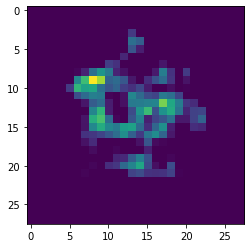

In [13]:
#데이터를 모델에 넣고 복우너시킵니다.
decoded_img = ae.predict(random_vector.reshape(1, 28*28))
decoded_img = decoded_img.reshape(28, 28)

#복원된 데이터 확인
plt.imshow(decoded_img)

In [14]:
np.mean(np.abs(random_vector - decoded_img.reshape(784,1)))
#its mean is this data is not trained data and higher MAE than trained data
# aply ->  we can set cut-off score like these situations normals have under 0.22 or novelties have over 0.45 

0.4722257466940391

In [15]:
#CAE
datax_reshape = datax_norm.reshape((-1, 28, 28, 1))
print('최대 : {}, 최소 : {}'.format(np.max(datax_norm), np.min(datax_norm)))

최대 : 1.0, 최소 : 0.0


In [16]:
## input
input_shape = (28, 28, 1)
input_tensor = layers.Input(input_shape)

## encoder
conv1 = layers.Conv2D(1, (3,3), padding='same', activation='relu')(input_tensor)
pooling1 = layers.MaxPool2D(name='imlatent_layer')(conv1)

flatten1 = layers.Flatten()(pooling1)

latent_tensor = flatten1

## Decoding
reshaped = tf.reshape(latent_tensor, [-1,14,14,1])

upsample2 = layers.UpSampling2D()(reshaped)
deconv2 = layers.Conv2DTranspose(1, (3,3), padding = 'same', activation='sigmoid')(upsample2 )

#outputs
output_tensor = deconv2

In [17]:
ae = models.Model(input_tensor, output_tensor)
ae.compile(optimizer = 'Adam', loss = 'mse')

In [18]:
ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 1)         10        
                                                                 
 imlatent_layer (MaxPooling2  (None, 14, 14, 1)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 14, 14, 1)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 1)        0         
 )                                                         

In [19]:
epoch = 10
batch_size = 1024
ae.fit(datax_reshape, datax_reshape, 
       batch_size = batch_size, 
       epochs = epoch, 
       verbose =2)

Epoch 1/10


2022-05-17 16:28:50.372134: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


59/59 - 1s - loss: 0.2155 - 1s/epoch - 23ms/step
Epoch 2/10
59/59 - 0s - loss: 0.1765 - 341ms/epoch - 6ms/step
Epoch 3/10
59/59 - 0s - loss: 0.1328 - 389ms/epoch - 7ms/step
Epoch 4/10
59/59 - 0s - loss: 0.0969 - 165ms/epoch - 3ms/step
Epoch 5/10
59/59 - 0s - loss: 0.0749 - 385ms/epoch - 7ms/step
Epoch 6/10
59/59 - 0s - loss: 0.0626 - 437ms/epoch - 7ms/step
Epoch 7/10
59/59 - 0s - loss: 0.0556 - 445ms/epoch - 8ms/step
Epoch 8/10
59/59 - 0s - loss: 0.0512 - 448ms/epoch - 8ms/step
Epoch 9/10
59/59 - 0s - loss: 0.0483 - 409ms/epoch - 7ms/step
Epoch 10/10
59/59 - 0s - loss: 0.0462 - 325ms/epoch - 6ms/step


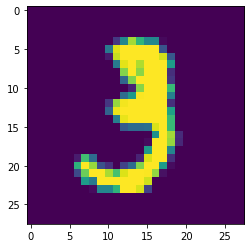

In [20]:
#원본 데이터 확인
plt.imshow(datax_reshape[10].reshape(28,28))

In [21]:
datax_reshape[10].shape

(28, 28, 1)

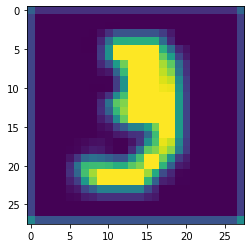

In [22]:
#데이터 복원
decoded_img = ae.predict(datax_reshape[10].reshape(1, 28,28,1))
decoded_img = decoded_img.reshape(28, 28)

plt.imshow(decoded_img)

In [23]:
intermediate_layer_model = models.Model(inputs=ae.input, outputs=ae.get_layer('imlatent_layer').output)
intermediate_output = intermediate_layer_model.predict(datax_reshape[10].reshape(1, 28,28, 1))

In [24]:
latent_vector = np.array(intermediate_output)

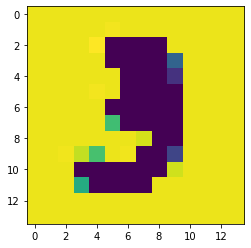

In [25]:
plt.imshow(latent_vector.reshape(14,14))

In [26]:
np.mean(np.abs(datax_reshape[10] - decoded_img.reshape(28,28)))

0.23248821088169166

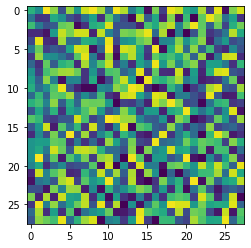

In [27]:
random_vector = np.random.rand(28, 28)
plt.imshow(random_vector)

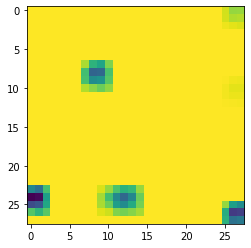

In [28]:
#데이터를 모델에 넣고 복우너시킵니다.
decoded_img = ae.predict(random_vector.reshape(-1, 28,28 ,1))
decoded_img = decoded_img.reshape(28, 28)

#복원된 데이터 확인
plt.imshow(decoded_img)

In [29]:
np.mean(np.abs(random_vector - decoded_img.reshape(28,28)))
#its mean is this data is not trained data and higher MAE than trained data
# aply ->  we can set cut-off score like these situations normals have under 0.22 or novelties have over 0.45 

0.265911913747503